In [1]:
#mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Notebooks/


/content/gdrive/MyDrive/Notebooks


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

## Loading saved vectors

In [2]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 51047)
shape of X_test_bow is (30000, 51047)
shape of X_train_tfidf is (70000, 51047)
shape of X_test_tfidf is (30000, 51047)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [3]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()


# Logistic regression

# Logistic Regression On Bow

Model with best parameters :
 {'C': 0.1, 'penalty': 'l2'}


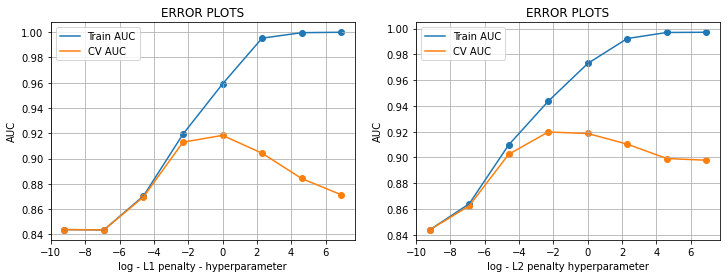

In [4]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_bow,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

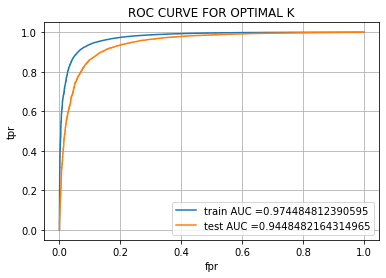

Area under train roc 0.974484812390595
Area under test roc 0.9448482164314965


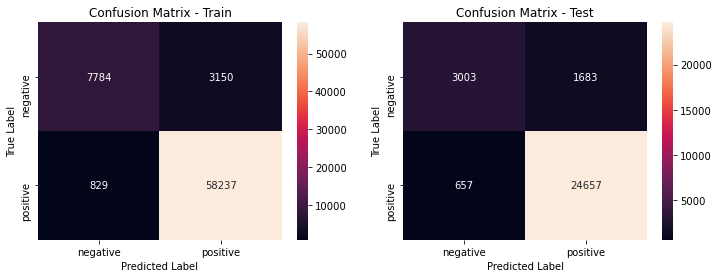

In [5]:

clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_bow,y_train,X_test_bow,y_test)

In [6]:
data_l2 = clf_l1_opt.coef_.reshape(-1,1)

datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=bow_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                     coef
worst          -1.860175
disappointing  -1.754299
terrible       -1.644231
disappointment -1.566010
awful          -1.560205
threw          -1.367053
horrible       -1.314491
unfortunately  -1.267509
disappointed   -1.222801
bland          -1.211211
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                coef
delicious  1.466225
excellent  1.414324
perfect    1.388634
highly     1.284219
wonderful  1.247395
awesome    1.206391
best       1.205367
great      1.170349
pleased    1.130122
loves      1.122476


# Logistic regression on TFIDF features

Model with best parameters :
 {'C': 10, 'penalty': 'l2'}


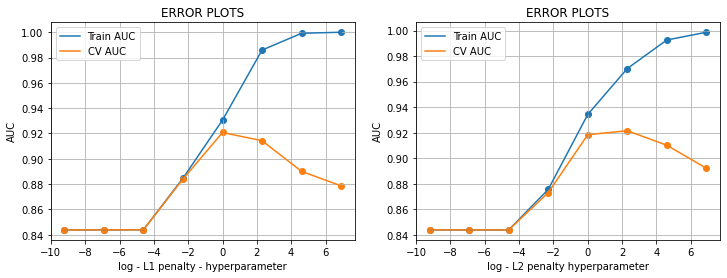

In [7]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_tfidf,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

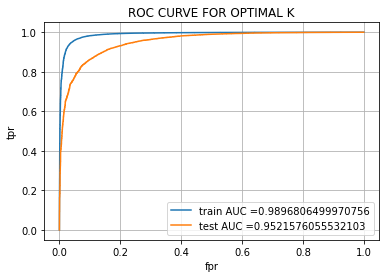

Area under train roc 0.9896806499970756
Area under test roc 0.9521576055532103


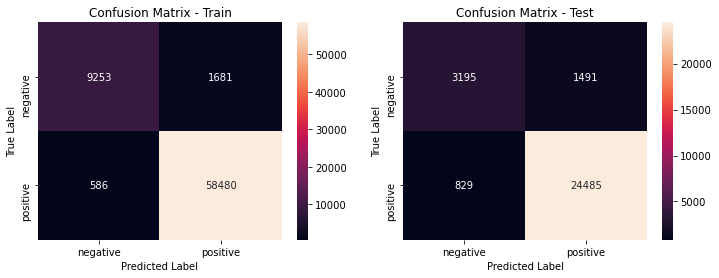

In [8]:

clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

In [9]:
data_l2 = clf_l1_opt.coef_.reshape(-1,1)

datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=tfidf_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                      coef
worst          -13.277423
disappointing  -11.431242
terrible       -11.264203
disappointment -10.694784
not             -9.962374
awful           -9.656265
threw           -9.411447
unacceptable    -8.910121
horrible        -8.902416
tasteless       -8.661791
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                 coef
great      15.324129
delicious  13.820661
best       13.088292
perfect    12.383757
excellent  11.275146
awesome    10.609966
wonderful  10.565051
highly     10.459629
good        9.617581
loves       9.345008


# Logistic regression on Average Word2Vec

Model with best parameters :
 {'C': 1, 'penalty': 'l1'}


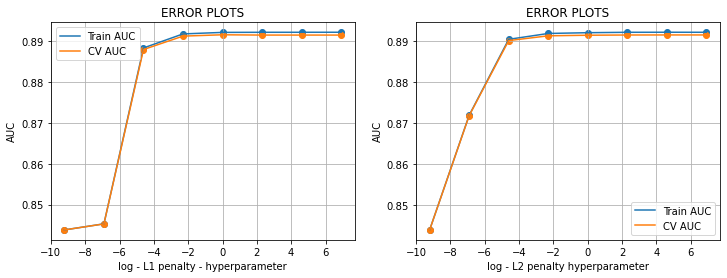

In [10]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_avgw2v,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

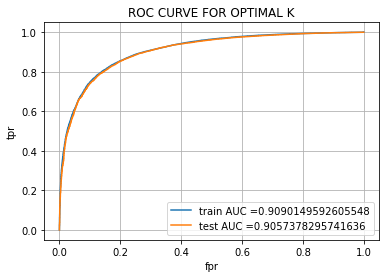

Area under train roc 0.9090149592605548
Area under test roc 0.9057378295741636


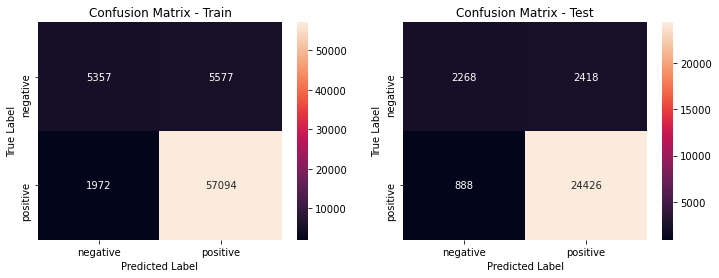

In [11]:

clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

# Logistic regression of TFIDF Word2Vec

Model with best parameters :
 {'C': 0.1, 'penalty': 'l1'}


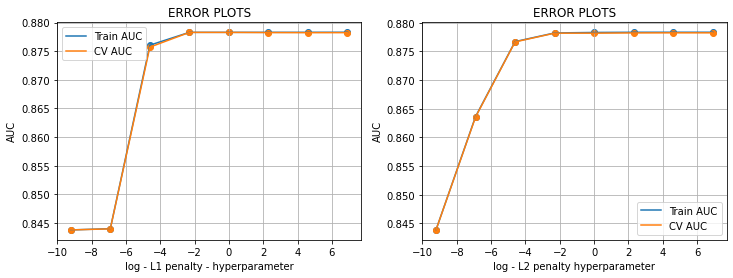

In [12]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_tfw2v,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

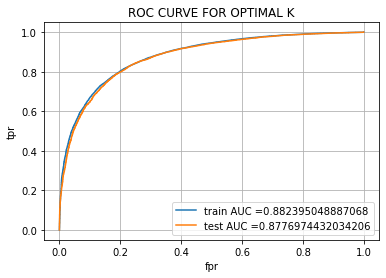

Area under train roc 0.882395048887068
Area under test roc 0.8776974432034206


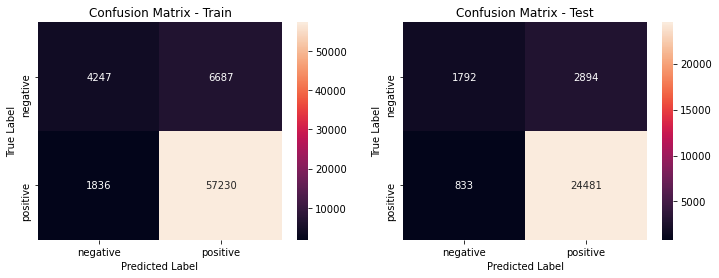

In [13]:

clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_tfw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_tfw2v,y_train,X_test_tfw2v,y_test)

# Observations and conclusions

In [14]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","regulariation", "Hyperparameter-C", "Train AUC", "Test AUC"]

z.add_row(["bow","logistic regression","l2",1,0.9915248995782959, 0.9405838148731518])
z.add_row(["tfidf","logistic regression","l2",0.1,0.9896589643778235,0.9545681039988041])    
z.add_row(["avg-word2vec","logistic regression","l2",10,0.9106441047112804,0.9109232272400278])
z.add_row(["tfidf-word2vec","logistic regression","l1",10,0.8857145235571816,0.8847929213341348])

print(z)

+----------------+---------------------+---------------+------------------+--------------------+--------------------+
|     Vector     |      Algorithm      | regulariation | Hyperparameter-C |     Train AUC      |      Test AUC      |
+----------------+---------------------+---------------+------------------+--------------------+--------------------+
|      bow       | logistic regression |       l2      |        1         | 0.9915248995782959 | 0.9405838148731518 |
|     tfidf      | logistic regression |       l2      |       0.1        | 0.9896589643778235 | 0.9545681039988041 |
|  avg-word2vec  | logistic regression |       l2      |        10        | 0.9106441047112804 | 0.9109232272400278 |
| tfidf-word2vec | logistic regression |       l1      |        10        | 0.8857145235571816 | 0.8847929213341348 |
+----------------+---------------------+---------------+------------------+--------------------+--------------------+
